## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/21f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In [1]:
from utils_3 import check_if_roman_numeral


In [4]:
SOS = '<'
EOS = '>'
PAD = '_'

sonnets = []
sonnet = []

for line in text:
    if line.strip():
        if check_if_roman_numeral(line.strip()):
            sonnets.append(SOS + ''.join(sonnet) + EOS)
            sonnet = []
            continue
        sonnet.append(line.lstrip().lower())


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = set(text)
tokens.add(EOS)
tokens.add(SOS)
tokens.add(PAD)
tokens = sorted(tokens)
num_tokens = len(tokens)
assert num_tokens == 41

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: c for i, c in enumerate(tokens)}


# dict <char>:<index>
# Your great code here
token_to_idx = {c: i for i, c in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
# Your code here
from models import RNN

In [9]:
from utils_3 import to_matrix, train_loop

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [10]:
train_loader = DataLoader(to_matrix(token_to_idx, sonnets), batch_size=32, shuffle=True)

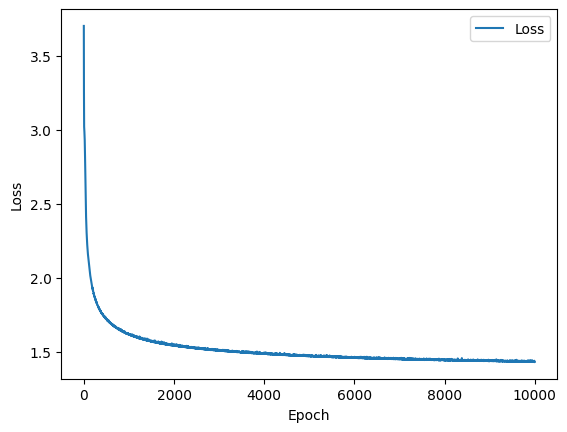

Final Loss: 1.4316303968429565


In [48]:
# Your plot code here
model = RNN(device=device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx[PAD])
n_epoch = 10000

train_loop(model=model, loss_func=loss_func, opt=opt, n_epoch=n_epoch, num_tokens=num_tokens, train_loader=train_loader, device=device)


In [49]:
def generate_sample(model, seed_phrase='<when', max_length=64, temperature=1.0, till_end=False):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    seed_phrase = seed_phrase.lower()
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    h_state = model.initial_state()
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, h_state = model(x_sequence[:, i].to(device), h_state)
    
    #start generating
    if till_end:
        next_ix = None
        while next_ix != token_to_idx[EOS]:
            out, h_state = model(x_sequence[:, -1].to(device), h_state)
            # Be really careful here with the model output
            p_next = F.softmax(out / temperature, dim=-1).cpu().data.numpy()[0]
            
            # sample next token and push it back into x_sequence
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0][:-1]])
    else:
        for _ in range(max_length - len(seed_phrase)):
            out, h_state = model(x_sequence[:, -1].to(device), h_state)
            # Be really careful here with the model output
            p_next = F.softmax(out / temperature, dim=-1).cpu().data.numpy()[0]
            
            # sample next token and push it back into x_sequence
            next_ix = np.random.choice(len(tokens), p=p_next)
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
            if next_ix == token_to_idx[EOS]:
                break
            x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        return ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])

In [51]:
# An example of generated text.
model.eval()
with torch.no_grad():
    for phrase in ['when', 'love', 'god', 'fair']:
        print(f'START WORD: {phrase}')
        for temperature in [0.1, 0.5, 1.0, 1.5]:
            print(f'Temeprature: {temperature}')
            print(generate_sample(model, seed_phrase=phrase, max_length=64, temperature=temperature))
            print("--------------")

START WORD: when
Temeprature: 0.1
whens thee thee,
and the stature the should the soul that the se
--------------
Temeprature: 0.5
whens eyes,
and the thoughts to the farth my love's rich yee.
o!
--------------
Temeprature: 1.0
whens i gives werk me,
unkind breast ever in focton thou toom fl
--------------
Temeprature: 1.5
whens.'st.
newly humourf i itlesly fack:
so unon makes budy even
--------------
START WORD: love
Temeprature: 0.1
love with the see,
and the should the world the shower of the se
--------------
Temeprature: 0.5
love me in thine,
thou despy seep a noter'd the crown there,
and
--------------
Temeprature: 1.0
love and lose prine,
and deid not with those earth's cilly gent 
--------------
Temeprature: 1.5
love 'siged,
spipk, darst, to compoon;, though forgeg held can
t
--------------
START WORD: god
Temeprature: 0.1
godeles state,
and the stature the should the should the see the
--------------
Temeprature: 0.5
godele of thee
true say the loss thou doth that worth and me

In [52]:
with torch.no_grad():
    for phrase in ['when', 'love', 'god', 'fair']:
        print(f'START WORD: {phrase}')
        print(generate_sample(model, seed_phrase=phrase, temperature=0.5, till_end=True))
        print("--------------")

START WORD: when
whens in thee,
but not sweet the sounction i would say,
the bare be the frainters being distoles
the stature bearst where the sour in thee the love,
which that what he love where with my end.
i so not the the thoughts and thou despain,
and love when the day thee time's some not,
that the wark my dead have others of the showed,
which that the shower made thou we himd of thou hold,
and thou beauty since that be the state,
and change be many is to your false thy sel
knenceme be thou art my tongues to day
that the star precious and thy sil the shouldst thee,
which making all the small the straight,
and the thoughts and the made the shall for my.

--------------
START WORD: love
love and mind preck,
my stremplerery in the world you and seen.

--------------
START WORD: god
goding thee,
and the strangerses and i crose me but it till,
and that that the seem''s my love the world doth gong
that thou that it the dead for the stature,
and the short of thy poor that in with thee:


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [1]:
# Your beautiful code here
from models import LSTM

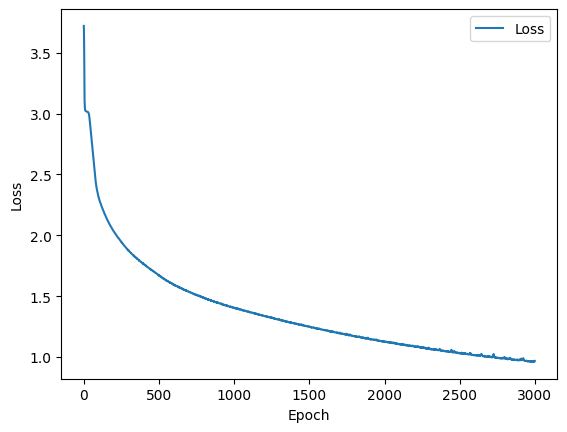

Final Loss: 0.9676273465156555


In [17]:
model = LSTM(device=device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx[PAD])
n_epoch = 3000

train_loop(model=model, loss_func=loss_func, opt=opt, n_epoch=n_epoch, num_tokens=num_tokens, train_loader=train_loader, device=device)

_Nicer loss in less epoch! LSTM with two layers definitely helped._

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [41]:
# Text generation with different temperature values here
model.eval()
with torch.no_grad():
    for phrase in ['when', 'love', 'god', 'fair']:
        for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
            print(f'Temeprature: {temperature}')
            print(generate_sample(model, seed_phrase=phrase, max_length=64, temperature=temperature))
            print("--------------")

Temeprature: 0.1
when evoom to my se song.

--------------
Temeprature: 0.2
when evoom to my se song.

--------------
Temeprature: 0.5
when evory i advace
for that thou are thing that heart beauty's 
--------------
Temeprature: 1.0
when eyef too, making our thee.

--------------
Temeprature: 2.0
when go,--sy may's sud, hur, i de goos,
by him took, ay thy gent
--------------
Temeprature: 0.1
love thoo has of me thou so shorng
after the love's earthers of 
--------------
Temeprature: 0.2
love thoo has of the hours truth!
wired to feed make my love to 
--------------
Temeprature: 0.5
love thoo has of you so;
or to shoust that therefore thou thysad
--------------
Temeprature: 1.0
love thoo yorcy as nouth,
sonkross sijarss, in by nonow illd's,

--------------
Temeprature: 2.0
love ace is,,, thou thow--lo longs wankers'ds. we:
the
of schent
--------------
Temeprature: 0.1
god ney
to sin lasce is my love she i am a corunge:
that i have 
--------------
Temeprature: 0.2
god levet lims's lit hat

_Higher temperature makes the generated texts more diverse. In our case seems like 0.5 is the best choice._

In [42]:
with torch.no_grad():
    for phrase in ['when', 'love', 'god', 'fair']:
        print(f'START WORD: {phrase}')
        print(generate_sample(model, seed_phrase=phrase, temperature=0.5, till_end=True))
        print("--------------")

START WORD: when
when each morn ward of self.
ore i think an them, and thou my love,
when in the carcaning hath more day,
and make them blind perourd in onristers'
or all my strong to ward of thee to myseld:
he i seem'd from lie to the ever much'd,
and is my wartent burtter of your sladse
and die tongues to men must be them so groan;
and in they shalt state of my singeds, now,
and thrants to the eyes age this from things,
comes what i may nouldst the pay please,
when i see to the sport in the wordnd:
such in the forly others' unirest thee.
i am for math can not do i woust,
that heaving thee will natur's of thee,
the once thou, the bountion 'gainst be member;
then, it in might see the unults cheare thee,
and i will me unsuch'd thou that beautst,
whilst i love should the count worth of love self-knot
thereforios, but the spirit of the dead
and sun my death, and make to the secay,
while thou things can my freech in my warine,
and in my peet beauty's sweet from sell,
and wook'd have somplo

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [46]:
# Saving and loading code here
path_to_save = 'lstm_model.pkl'
torch.save(model.state_dict(), path_to_save)

model_loaded = LSTM(device=device)
model_loaded.load_state_dict(torch.load(path_to_save))

model_loaded.eval()
with torch.no_grad():
    print(generate_sample(model_loaded, seed_phrase='That thereby beauty\'s rose might never ', temperature=0.5, till_end=True))

that thereby beauty's rose might never rude,
rysons isstor thou false thee to be come,
that make the travel one old of thines of pleasure:
then rich in thee, when my heart to men mine,
thy loshing that his false to come not seld:
then mine eyes, and their spiking of youth thee count,
and more new authory beauty's best in me.



_Conclusion: results look pretty good, considering that not words, but letters were taken as tokens. Results have structure and a lot of words make sense. Still model invents new words or it can simply be some medieval english, hard to say sometimes :)._

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)